<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title"></span> The following notes written by  <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName"> Arturo Fredes Cáceres and Sergio Gutiérrez Rodrigo (<sergut@unizar.es>) </span>. Distributed under  <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">License Creative Commons Atribución-NoComercial-CompartirIgual 4.0 Internacional</a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Mount Google Drive

In [ ]:
#Montar el drive e ir a la carpeta
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
%cd /content/drive/MyDrive/tfg_arturo_fredes/
%ls -lht

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/14vm5MGzqG524llIllY_y_2zZi54Re8hx/tfg_arturo_fredes
total 3.6G
-rw------- 1 root root 1.6M Aug 29 21:57 'Toy model.ipynb'
-rw------- 1 root root 3.3M Aug 23 15:57  Lorenz_Attractor.ipynb
-rw------- 1 root root 111K Aug 19 14:23  plot.png
drwx------ 2 root root 4.0K Aug 19 10:45  modelos/
-rw------- 1 root root  181 Aug  9 20:54  Resultados.gsheet
-rw------- 1 root root 1.7M Aug  9 20:46  iterpredLorenz.txt
-rw------- 1 root root 833K Aug  8 11:27  iterpred2.txt
-rw------- 1 root root 835K Aug  8 10:27  iterpred1.txt
-rw------- 1 root root  46K Aug  8 09:19  Lorenz_Iter_LSTM_proj_1.png
-rw------- 1 root root  44K Aug  8 09:19  Lorenz_S-VLSTM_proj_1.png
-rw------- 1 root root 118K Aug  8 09:18  Lorenz_S-VLSTM_3D_1.png
-rw------- 1 root root 116K Aug  8 09:18  Lorenz_Iter_LSTM_3D_1.png
-rw------- 1 root root  45K Aug  8 09:15  Lorenz_Iter_LSTM_proj_0.png
-rw------- 1 root root 124K Aug  8 09:15  Lorenz_Iter_LSTM_3D_0.png
-r

# Generating Data

In [ ]:
def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)#genera 4 vectores de numeros aleatorios de longitud batch_size
  time = np.linspace(0, 1, n_steps)
  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise
  return series[..., np.newaxis].astype(np.float32)

In [ ]:
#generate new data with targets of length 10
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
#Saving data
file_path = './datatoy.txt'
data_2D = series.reshape(-1, series.shape[-1])
np.savetxt(file_path, data_2D, fmt='%.8f')


In [ ]:
print(X_train.shape,y_train.shape)

(7000, 50, 1) (7000, 1)


# Reading data

In [ ]:

# Load the data from the text document
#file_path = '/content/drive/MyDrive/tfg_arturo_fredes/data1.txt'
file_path = 'datatoy.txt' #data3.txt = small dataset
series = np.loadtxt(file_path, dtype=float)

series = series.reshape(10000, 60)

# Step 2: Add a new axis to make it (10000, 60, 1)
series = series[:, :, np.newaxis]
print(series.shape)

(10000, 60, 1)


In [ ]:
#Dividing data
n_steps = 50
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

# Predicting One Timestep

## Baselines
We set the Baseline of our problem.


1.   Predicting the last value --> MSE 0.02
2.   Dense NN ('Adam', 20 Epochs)--> MSE 0.004



In [ ]:
#BASELINE1
#we predict the last value from each series
y_pred = X_test[:, -1]
print('MSE: ')
np.mean(tf.keras.losses.mean_squared_error(Y_test, y_pred))

MSE: 


0.256520477677297

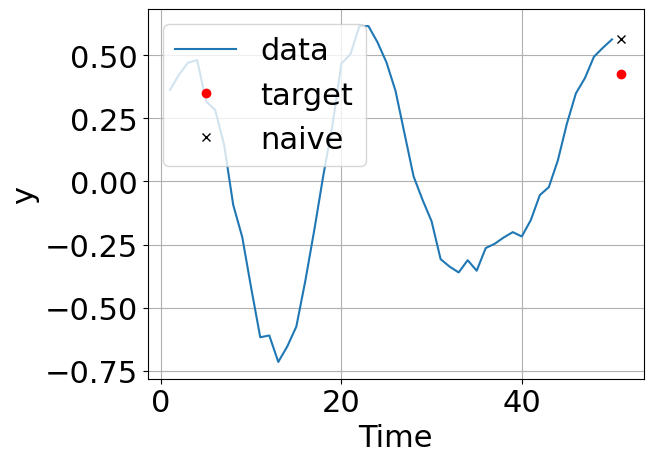

tf.Tensor(0.857325000229262, shape=(), dtype=float64)


In [ ]:

# Create the plot
j=np.random.randint(X_test.shape[0])
plt.rcParams.update({'font.size': 22})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data')
plt.plot(51,Y_test[j][0],'ro',label='target')
plt.plot(51,X_test[j][49][0],'x',color='black',label='naive')
plt.xlabel('Time')
plt.ylabel('y')
plt.grid(True)
plt.legend(loc='upper left')

plt.savefig('./Memoria/Toy model/Toynaive{j}.png'.format(j=j))
# Show the plot
plt.show()

print(tf.keras.losses.mean_squared_error(Y_test[j], X_train[j,-1]))



## Comparing Neurons


### Feedforward neuron

In [ ]:

model1 = tf.keras.models.Sequential([
tf.keras.layers.Flatten(input_shape=[50, 1]),
tf.keras.layers.Dense(1)
])

model1.summary()
model1.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history=model1.fit(X_train, Y_train[:,0], epochs=20, validation_data=(X_valid, Y_valid[:,0]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
219/219 [==============================] - 5s 10ms/step - loss: 0.1040 - mae: 0.2507 - val_loss: 0.0340 - val_mae: 0.1526
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0181 - mae: 0.1091 - val_loss: 0.0106 - val_mae: 0.0838
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0084 - mae: 0.0741 - val_loss: 0.0073 - val_mae: 0.0682
Epoch 4/20
219/219 [==============================] - 1s 3m

In [ ]:
ypred=model1.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(y_test, ypred))

32/32 [==============================] - 0s 2ms/step


0.0041065672

In [ ]:
model1.save('/content/drive/MyDrive/tfg_arturo_fredes/Toy_DN.h5',save_format='h5')

In [ ]:
model1=tf.keras.models.load_model('/content/drive/MyDrive/tfg_arturo_fredes/Toy_DN.h5')

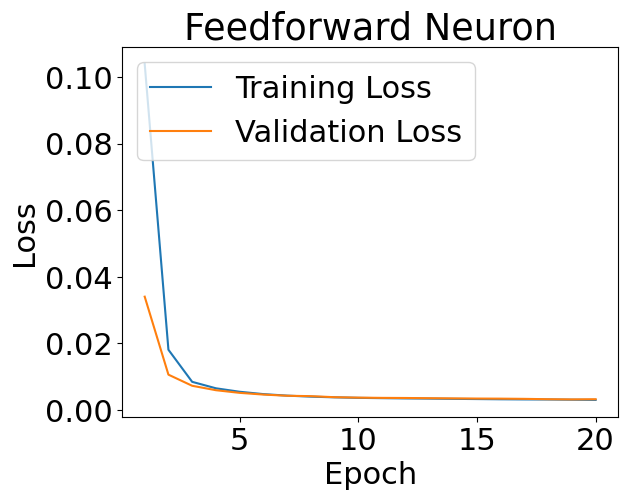

In [ ]:
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)

# Extract the validation loss values
val_loss = history.history['val_loss']

# Plot the training loss and validation loss vs. epoch
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Feedforward Neuron')
plt.legend(loc='upper left')
plt.show()


1/1 [==============================] - 0s 27ms/step
(1, 1)


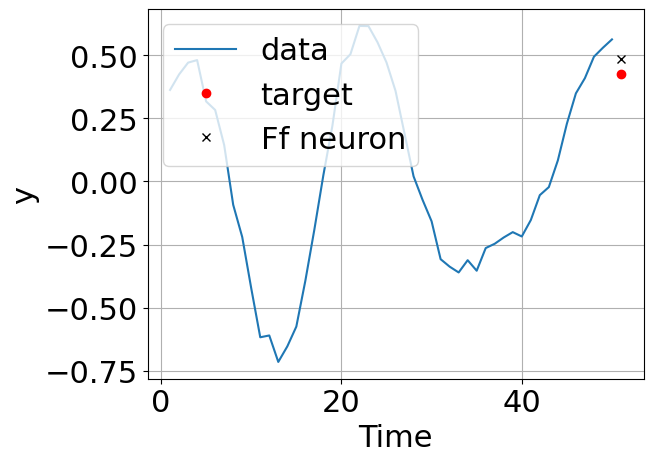

tf.Tensor(0.655416, shape=(), dtype=float32)


In [ ]:
# Create the plot
j=np.random.randint(X_test.shape[0])

plt.rcParams.update({'font.size': 22})
pred=model1.predict(X_test[j].reshape(1, 50, 1))
print(pred.shape)
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data')
plt.plot(51,Y_test[j][0],'ro',label='target')
plt.plot(51,pred[0][0],'x',color='black',label='Ff neuron')
plt.xlabel('Time')
plt.ylabel('y')
plt.grid(True)
plt.legend(loc='upper left')
plt.savefig('./Memoria/Toy model/ToyDN{j}.png'.format(j=j))
# Show the plot
plt.show()

print(tf.keras.losses.mean_squared_error(Y_test[j], pred[0]))


In [ ]:
pred[0][0]


-0.19077097

### Single recursive cell
Now we will build a model with a single cell, the simplest there can be.
MSE--> 0.014
we beat the naive model, but not the dense network. Our model only has 3 parameters vs 51 in the other network. It is too simple.

In [ ]:
model2 = tf.keras.models.Sequential([
tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])])
#by deafault, it will only return the last output, hyperbolic tangent activation
#initial sate is set to 0

#We do not need to specify the length of the
#input sequences (unlike in the previous model), since a recurrent neural network can
#process any number of time steps (this is why we set the first input dimension to None)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history=model2.fit(X_train, Y_train[:,0], epochs=20, validation_data=(X_valid, Y_valid[:,0]))

Epoch 1/20
219/219 [==============================] - 12s 48ms/step - loss: 0.0137 - mae: 0.0934 - val_loss: 0.0112 - val_mae: 0.0847
Epoch 2/20
219/219 [==============================] - 14s 64ms/step - loss: 0.0100 - mae: 0.0805 - val_loss: 0.0099 - val_mae: 0.0798
Epoch 3/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0094 - mae: 0.0781 - val_loss: 0.0096 - val_mae: 0.0785
Epoch 4/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0092 - mae: 0.0772 - val_loss: 0.0094 - val_mae: 0.0779
Epoch 5/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0090 - mae: 0.0767 - val_loss: 0.0093 - val_mae: 0.0776
Epoch 6/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0089 - mae: 0.0764 - val_loss: 0.0093 - val_mae: 0.0777
Epoch 7/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0089 - mae: 0.0762 - val_loss: 0.0092 - val_mae: 0.0778
Epoch 8/20
219/219 [==============================] - 8s 36ms/step

In [ ]:
ypred=model2.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test[:,0], ypred))

32/32 [==============================] - 0s 10ms/step


0.238135

In [ ]:
model2.save('./Toy_SimpleRNN.h5',save_format='h5')

In [ ]:
model2=tf.keras.models.load_model('./Toy_SimpleRNN.h5')

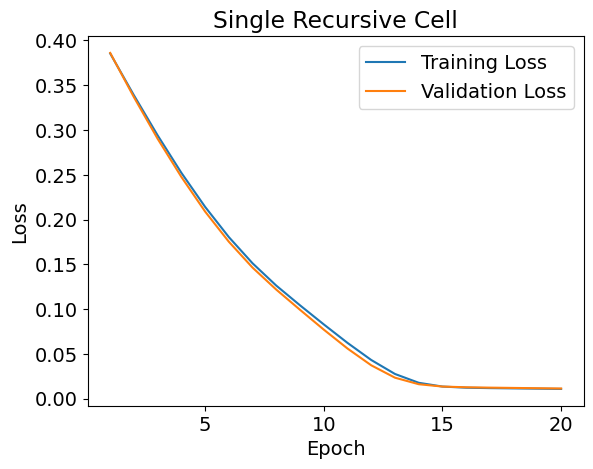

In [ ]:
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)

# Extract the validation loss values
val_loss = history.history['val_loss']

# Plot the training loss and validation loss vs. epoch
plt.rcParams.update({'font.size': 14})
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Recursive Cell')
plt.legend()
plt.show()


1/1 [==============================] - 0s 23ms/step


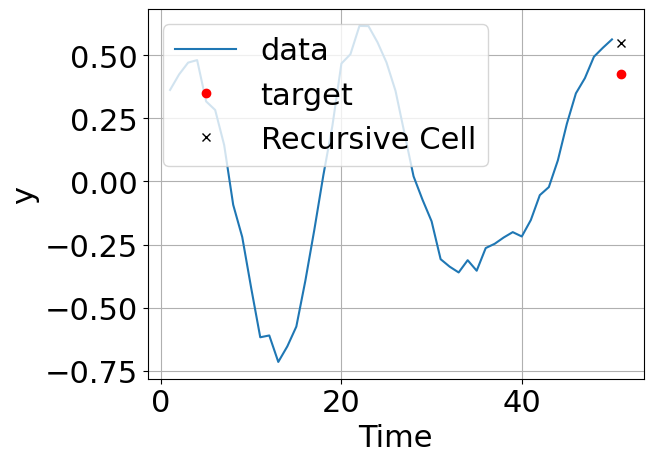

tf.Tensor(0.74890536, shape=(), dtype=float32)


In [ ]:
# Create the plot
j=np.random.randint(X_test.shape[0])

pred=model2.predict(X_test[j].reshape(1, 50, 1))

plt.rcParams.update({'font.size': 22})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data')
plt.plot(51,Y_test[j][0],'ro',label='target')
plt.plot(51,pred[0][0],'x',color='black',label='Recursive Cell')
plt.xlabel('Time')
plt.ylabel('y')
plt.grid(True)
plt.legend(loc='upper left')

plt.savefig('./Memoria/Toy model/ToyRN{j}.png'.format(j=j))
# Show the plot
plt.show()

print(tf.keras.losses.mean_squared_error(Y_test[j], pred[0]))

### LSTM

In [ ]:
model3 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(1, input_shape=[None, 1])])
#by deafault, it will only return the last output, hyperbolic tangent activation
#initial sate is set to 0

#We do not need to specify the length of the
#input sequences (unlike in the previous model), since a recurrent neural network can
#process any number of time steps (this is why we set the first input dimension to None)
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1)                 12        
                                                                 
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history=model3.fit(X_train, Y_train[:,0], epochs=20, validation_data=(X_valid, Y_valid[:,0]))

Epoch 1/20
219/219 [==============================] - 4s 11ms/step - loss: 0.0681 - mae: 0.2053 - val_loss: 0.0664 - val_mae: 0.2026
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0550 - mae: 0.1843 - val_loss: 0.0513 - val_mae: 0.1794
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0409 - mae: 0.1597 - val_loss: 0.0374 - val_mae: 0.1550
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0298 - mae: 0.1378 - val_loss: 0.0278 - val_mae: 0.1355
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0226 - mae: 0.1213 - val_loss: 0.0218 - val_mae: 0.1212
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0181 - mae: 0.1095 - val_loss: 0.0179 - val_mae: 0.1104
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0153 - mae: 0.1009 - val_loss: 0.0154 - val_mae: 0.1026
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0

In [ ]:
model3.save('./Toy_lstmN.h5',save_format='h5')

In [ ]:
model3=tf.keras.models.load_model('./Toy_lstmN.h5')

In [ ]:
ypred=model3.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(y_test, ypred))

32/32 [==============================] - 0s 2ms/step


0.012390113

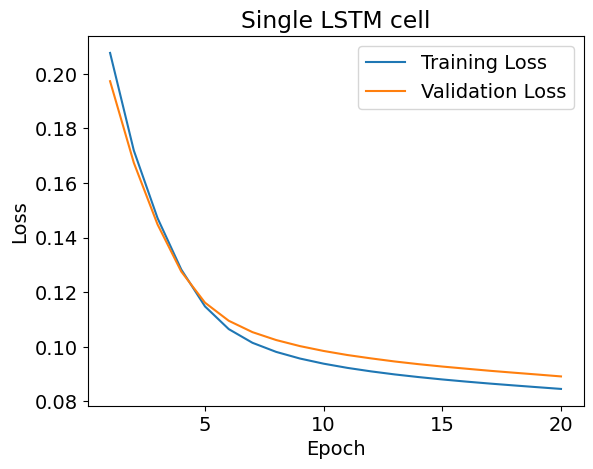

In [ ]:
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)

# Extract the validation loss values
val_loss = history.history['val_loss']

# Plot the training loss and validation loss vs. epoch
plt.rcParams.update({'font.size': 14})
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Single LSTM cell')
plt.legend(loc='upper left')
plt.show()


1/1 [==============================] - 0s 20ms/step


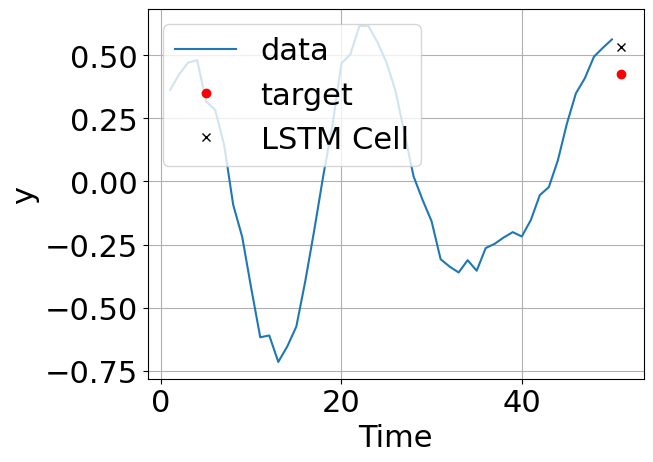

tf.Tensor(0.72540647, shape=(), dtype=float32)


In [ ]:
# Create the plot
j=np.random.randint(X_test.shape[0])

pred=model3.predict(X_test[j].reshape(1, 50, 1))
plt.rcParams.update({'font.size': 22})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data')
plt.plot(51,Y_test[j][0],'ro',label='target')
plt.plot(51,pred[0][0],'x',color='black',label='LSTM Cell')
plt.xlabel('Time')
plt.ylabel('y')
plt.grid(True)
plt.legend(loc='upper left')

plt.savefig('./Memoria/Toy model/ToylstmN{j}.png'.format(j=j))
# Show the plot
plt.show()

print(tf.keras.losses.mean_squared_error(Y_test[j], pred[0]))

### GRU

In [ ]:
model4 = tf.keras.models.Sequential([
tf.keras.layers.GRU(1, input_shape=[None, 1])])
#by deafault, it will only return the last output, hyperbolic tangent activation
#initial sate is set to 0

#We do not need to specify the length of the
#input sequences (unlike in the previous model), since a recurrent neural network can
#process any number of time steps (this is why we set the first input dimension to None)
model4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 1)                 12        
                                                                 
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model4.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history=model4.fit(X_train, Y_train[:,0], epochs=20, validation_data=(X_valid, Y_valid[:,0]))

Epoch 1/20
219/219 [==============================] - 6s 16ms/step - loss: 0.0419 - mae: 0.1676 - val_loss: 0.0368 - val_mae: 0.1595
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0304 - mae: 0.1425 - val_loss: 0.0280 - val_mae: 0.1392
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0238 - mae: 0.1263 - val_loss: 0.0225 - val_mae: 0.1247
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0195 - mae: 0.1143 - val_loss: 0.0188 - val_mae: 0.1137
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0165 - mae: 0.1050 - val_loss: 0.0160 - val_mae: 0.1049
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0143 - mae: 0.0977 - val_loss: 0.0141 - val_mae: 0.0982
Epoch 7/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0127 - mae: 0.0921 - val_loss: 0.0127 - val_mae: 0.0930
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss

In [ ]:
model4.save('./Toy_gruN.h5',save_format='h5')

In [ ]:
model4=tf.keras.models.load_model('./Toy_gruN.h5')

In [ ]:
ypred=model4.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(y_test, ypred))

32/32 [==============================] - 0s 2ms/step


0.01231122

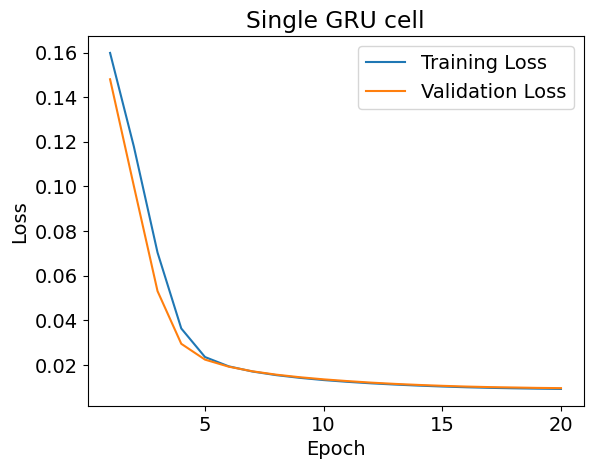

In [ ]:
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)

# Extract the validation loss values
val_loss = history.history['val_loss']

# Plot the training loss and validation loss vs. epoch
plt.rcParams.update({'font.size': 14})
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Single GRU cell')
plt.legend()
plt.show()

1/1 [==============================] - 0s 23ms/step


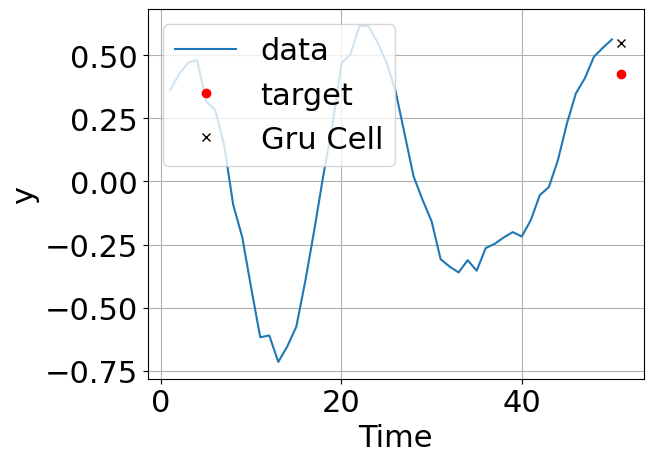

tf.Tensor(0.7493618, shape=(), dtype=float32)


In [ ]:
# Create the plot
j=np.random.randint(X_test.shape[0])

pred=model4.predict(X_test[j].reshape(1, 50, 1))
plt.rcParams.update({'font.size': 22})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data')
plt.plot(51,Y_test[j][0],'ro',label='target')
plt.plot(51,pred[0][0],'x',color='black',label='Gru Cell')
plt.xlabel('Time')
plt.ylabel('y')
plt.grid(True)
plt.legend(loc='upper left')

plt.savefig('./Memoria/Toy model/ToygruN{j}.png'.format(j=j))
# Show the plot
plt.show()

print(tf.keras.losses.mean_squared_error(Y_test[j], pred[0]))

## Comparing Networks

###DNN

In [ ]:
model5 = tf.keras.models.Sequential([
tf.keras.layers.Flatten(input_shape=[50, 1]),
tf.keras.layers.Dense(20),
tf.keras.layers.Dense(20),
tf.keras.layers.Dense(1)
])

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,461
Trainable params: 1,461
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model5.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history=model5.fit(X_train, Y_train[:,0], epochs=20, validation_data=(X_valid, Y_valid[:,0]))

Epoch 1/20
219/219 [==============================] - 2s 4ms/step - loss: 0.0441 - mae: 0.1439 - val_loss: 0.0084 - val_mae: 0.0737
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0058 - mae: 0.0612 - val_loss: 0.0046 - val_mae: 0.0542
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0045 - mae: 0.0539 - val_loss: 0.0041 - val_mae: 0.0513
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0040 - mae: 0.0508 - val_loss: 0.0039 - val_mae: 0.0498
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0036 - mae: 0.0482 - val_loss: 0.0034 - val_mae: 0.0463
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0034 - mae: 0.0466 - val_loss: 0.0033 - val_mae: 0.0460
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0032 - mae: 0.0454 - val_loss: 0.0032 - val_mae: 0.0452
Epoch 8/20
219/219 [==============================] - 1s 5ms/step - loss: 0.

In [ ]:
model5.save('./Toy_DNN.h5',save_format='h5')

In [ ]:
model5=tf.keras.models.load_model('./Toy_DNN.h5')

In [ ]:
ypred=model5.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(y_test, ypred))

32/32 [==============================] - 0s 1ms/step


0.0032306176

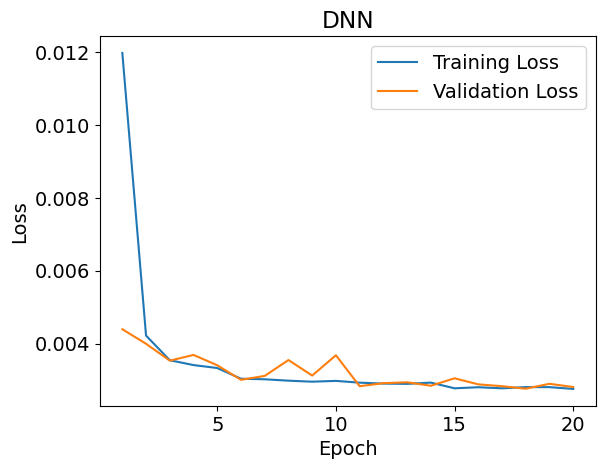

In [ ]:
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)

# Extract the validation loss values
val_loss = history.history['val_loss']

# Plot the training loss and validation loss vs. epoch
plt.rcParams.update({'font.size': 14})
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DNN')
plt.legend()
plt.show()


1/1 [==============================] - 0s 19ms/step


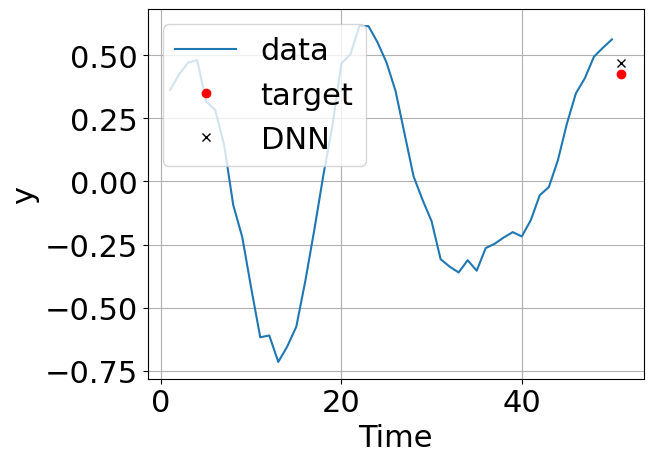

tf.Tensor(0.6376201, shape=(), dtype=float32)


In [ ]:
# Create the plot
j=np.random.randint(X_test.shape[0])

pred=model5.predict(X_test[j].reshape(1, 50, 1))
plt.rcParams.update({'font.size': 22})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data')
plt.plot(51,Y_test[j][0],'ro',label='target')
plt.plot(51,pred[0][0],'x',color='black',label='DNN')
plt.xlabel('Time')
plt.ylabel('y')
plt.grid(True)
plt.legend(loc='upper left')

plt.savefig('./Memoria/Toy model/ToyDNN{j}.png'.format(j=j))
# Show the plot
plt.show()

print(tf.keras.losses.mean_squared_error(Y_test[j], pred[0]))

### Deep RNN
stack multiple layers of cells
MSE--> 0.0027 we beat the baseline!

In [ ]:
model6 = tf.keras.models.Sequential([
tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
tf.keras.layers.SimpleRNN(20, return_sequences=True),
tf.keras.layers.SimpleRNN(1)
])

model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model6.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history=model6.fit(X_train, Y_train[:,0], epochs=20, validation_data=(X_valid, Y_valid[:,0]))

In [ ]:
model6=tf.keras.models.load_model()

In [ ]:
ypred=model6.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(y_test, ypred))

In [ ]:
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)

# Extract the validation loss values
val_loss = history.history['val_loss']

# Plot the training loss and validation loss vs. epoch
plt.rcParams.update({'font.size': 14})
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Deep RNN 1')
plt.legend()
plt.show()


1/1 [==============================] - 0s 28ms/step


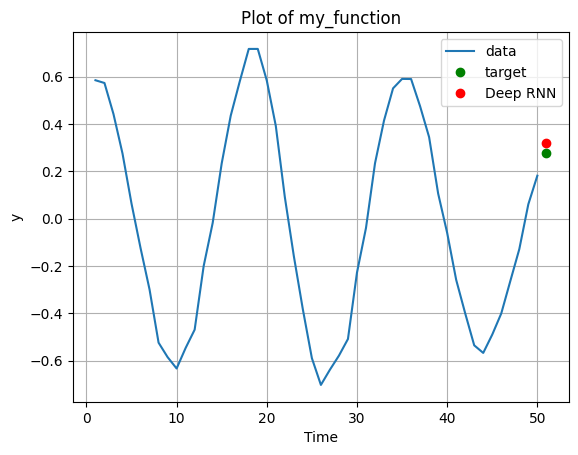

In [ ]:
# Create the plot
j=np.random.randint(X_test.shape[0])
j=0
pred=model6.predict(X_test[j].reshape(1, 50, 1))
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data')
plt.plot(51,Y_test[j][0],'go',label='target')
plt.plot(51,pred[0][0],'ys',label='Deep RNN')
plt.xlabel('Time')
plt.ylabel('y')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

Make sure to set return_sequences=True for all recurrent layers
(except the last one, if you only care about the last output). If you
don’t, they will output a 2D array (containing only the output of
the last time step) instead of a 3D array (containing outputs for all
time steps), and the next recurrent layer will complain that you are
not feeding it sequences in the expected 3D format.

The last layer is not ideal:


1.   Cannot choose activation function
2.   it must have a single unit because we want to forecast
a univariate time series, and this means we must have a single output value per
time step. However, having a single unit means that the hidden state is just a single
number. That’s really not much, and it’s probably not that useful; presumably, the
RNN will mostly use the hidden states of the other recurrent layers to carry over all
the information it needs from time step to time step, and it will not use the final layer’s
hidden state very much

We can use a Dense layer to solve this problems. MSE is similar, but it is more efficient.


In [ ]:
model7 = tf.keras.models.Sequential([
tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
tf.keras.layers.SimpleRNN(20),
tf.keras.layers.Dense(1)
])

model7.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model7.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history=model7.fit(X_train, Y_train[:,0], epochs=20, validation_data=(X_valid, Y_valid[:,0]))

Epoch 1/20
219/219 [==============================] - 39s 163ms/step - loss: 0.0158 - mae: 0.0888 - val_loss: 0.0043 - val_mae: 0.0526
Epoch 2/20
219/219 [==============================] - 33s 149ms/step - loss: 0.0036 - mae: 0.0476 - val_loss: 0.0031 - val_mae: 0.0449
Epoch 3/20
219/219 [==============================] - 21s 94ms/step - loss: 0.0030 - mae: 0.0435 - val_loss: 0.0028 - val_mae: 0.0430
Epoch 4/20
219/219 [==============================] - 24s 108ms/step - loss: 0.0028 - mae: 0.0424 - val_loss: 0.0029 - val_mae: 0.0436
Epoch 5/20
219/219 [==============================] - 22s 101ms/step - loss: 0.0028 - mae: 0.0422 - val_loss: 0.0029 - val_mae: 0.0436
Epoch 6/20
219/219 [==============================] - 21s 96ms/step - loss: 0.0026 - mae: 0.0410 - val_loss: 0.0027 - val_mae: 0.0420
Epoch 7/20
219/219 [==============================] - 23s 103ms/step - loss: 0.0026 - mae: 0.0411 - val_loss: 0.0028 - val_mae: 0.0427
Epoch 8/20
219/219 [==============================] - 21s

In [ ]:
model7.save('./Toy_RNN.h5',save_format='h5')

In [ ]:
model7=tf.keras.models.load_model('./Toy_RNN.h5')

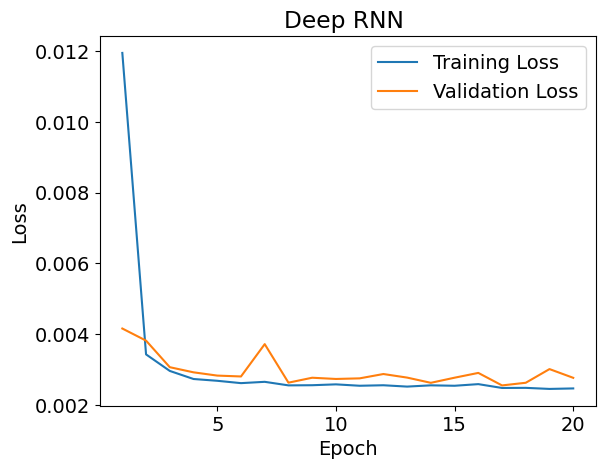

In [ ]:
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)

# Extract the validation loss values
val_loss = history.history['val_loss']

# Plot the training loss and validation loss vs. epoch
plt.rcParams.update({'font.size': 14})
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Deep RNN ')
plt.legend()
plt.show()


1/1 [==============================] - 0s 233ms/step


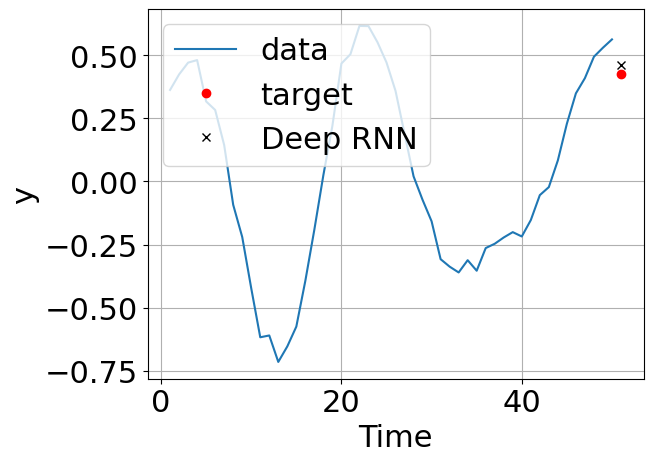

tf.Tensor(0.6268066, shape=(), dtype=float32)


In [ ]:
# Create the plot
j=np.random.randint(X_test.shape[0])

pred=model7.predict(X_test[j].reshape(1, 50, 1))
plt.rcParams.update({'font.size': 22})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data')
plt.plot(51,Y_test[j][0],'ro',label='target')
plt.plot(51,pred[0][0],'x',color='black',label='Deep RNN')
plt.xlabel('Time')
plt.ylabel('y')
plt.grid(True)
plt.legend(loc='upper left')


plt.savefig('./Memoria/Toy model/ToyRNN{j}.png'.format(j=j))
# Show the plot
plt.show()

print(tf.keras.losses.mean_squared_error(Y_test[j], pred[0]))

### LSTM Network

In [ ]:
model8 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
tf.keras.layers.LSTM(20),
tf.keras.layers.Dense(1)
])

model8.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, None, 20)          1760      
                                                                 
 lstm_2 (LSTM)               (None, 20)                3280      
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model8.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history=model8.fit(X_train, Y_train[:,0], epochs=20, validation_data=(X_valid, Y_valid[:,0]))

Epoch 1/20
219/219 [==============================] - 6s 12ms/step - loss: 0.0461 - mae: 0.1711 - val_loss: 0.0253 - val_mae: 0.1299
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0181 - mae: 0.1087 - val_loss: 0.0114 - val_mae: 0.0861
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0071 - mae: 0.0661 - val_loss: 0.0039 - val_mae: 0.0506
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0032 - mae: 0.0447 - val_loss: 0.0028 - val_mae: 0.0423
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0027 - mae: 0.0418 - val_loss: 0.0027 - val_mae: 0.0418
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0027 - mae: 0.0414 - val_loss: 0.0030 - val_mae: 0.0442
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0025 - mae: 0.0405 - val_loss: 0.0026 - val_mae: 0.0412
Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss:

In [ ]:
model8.save('/content/drive/MyDrive/tfg_arturo_fredes/Toy_LSTM.h5',save_format='h5')

In [ ]:
model8=tf.keras.models.load_model('./Toy_LSTM.h5')

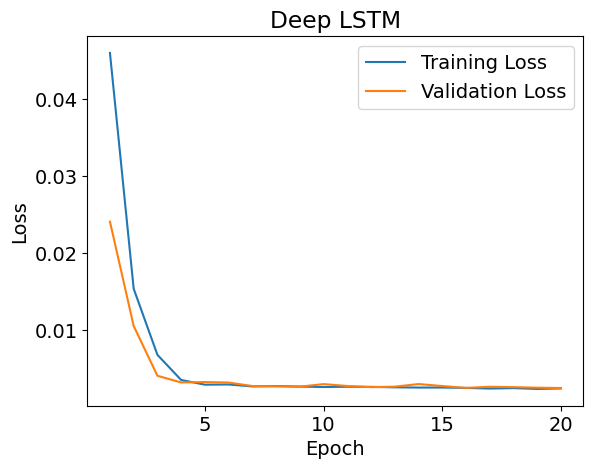

In [ ]:
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)

# Extract the validation loss values
val_loss = history.history['val_loss']

# Plot the training loss and validation loss vs. epoch
plt.rcParams.update({'font.size': 14})
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Deep LSTM')
plt.legend()
plt.show()

1/1 [==============================] - 0s 38ms/step


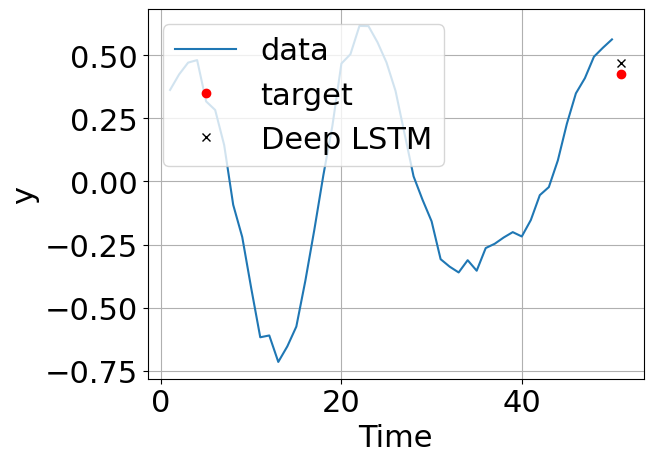

tf.Tensor(0.6341716, shape=(), dtype=float32)


In [ ]:
# Create the plot
j=np.random.randint(X_test.shape[0])

pred=model8.predict(X_test[j].reshape(1, 50, 1))
plt.rcParams.update({'font.size': 22})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data')
plt.plot(51,Y_test[j][0],'ro',label='target')
plt.plot(51,pred[0][0],'x',color='black',label='Deep LSTM')
plt.xlabel('Time')
plt.ylabel('y')

plt.grid(True)
plt.legend(loc='upper left')

plt.savefig('./Memoria/Toy model/ToylstmNN{j}.png'.format(j=j))
# Show the plot
plt.show()

print(tf.keras.losses.mean_squared_error(Y_test[j], pred[0]))



### GRU Network

In [ ]:
model9 = tf.keras.models.Sequential([
tf.keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
tf.keras.layers.GRU(20),
tf.keras.layers.Dense(1)
])

model9.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, None, 20)          1380      
                                                                 
 gru_2 (GRU)                 (None, 20)                2520      
                                                                 
 dense_6 (Dense)             (None, 1)                 21        
                                                                 
Total params: 3,921
Trainable params: 3,921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model9.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history=model9.fit(X_train, Y_train[:,0], epochs=20, validation_data=(X_valid, Y_valid[:,0]))

Epoch 1/20
219/219 [==============================] - 9s 23ms/step - loss: 0.0228 - mae: 0.1142 - val_loss: 0.0059 - val_mae: 0.0615
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0043 - mae: 0.0530 - val_loss: 0.0040 - val_mae: 0.0512
Epoch 3/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0038 - mae: 0.0496 - val_loss: 0.0039 - val_mae: 0.0507
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0038 - mae: 0.0495 - val_loss: 0.0039 - val_mae: 0.0502
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0036 - mae: 0.0478 - val_loss: 0.0035 - val_mae: 0.0479
Epoch 6/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0035 - mae: 0.0475 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 7/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0035 - mae: 0.0476 - val_loss: 0.0038 - val_mae: 0.0500
Epoch 8/20
219/219 [==============================] - 3s 14ms/step - 

In [ ]:
model9.save('./Toy_gruNN.h5',save_format='h5')

In [ ]:
model9=tf.keras.models.load_model('./Toy_gruNN.h5')

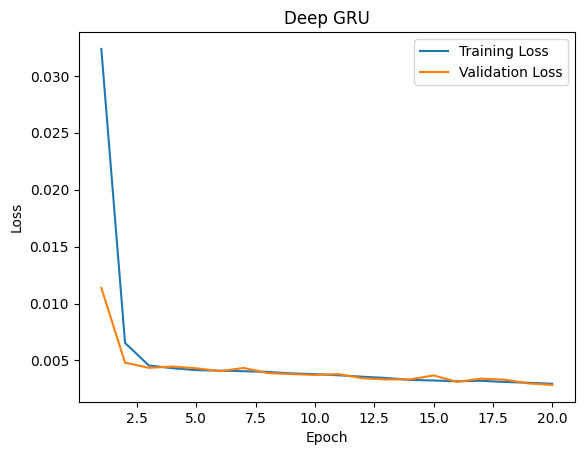

In [ ]:
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)

# Extract the validation loss values
val_loss = history.history['val_loss']

# Plot the training loss and validation loss vs. epoch
plt.rcParams.update({'font.size': 14})
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Deep GRU')
plt.legend()
plt.show()

1/1 [==============================] - 0s 58ms/step


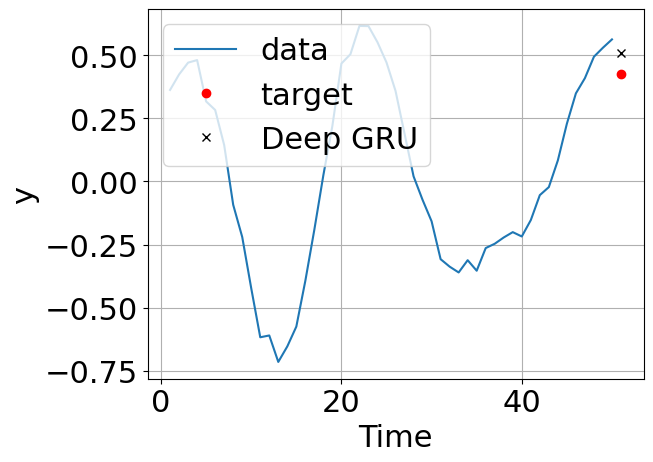

tf.Tensor(0.6893327, shape=(), dtype=float32)


In [ ]:
# Create the plot
j=np.random.randint(X_test.shape[0]) #SGR

pred=model9.predict(X_test[j].reshape(1, 50, 1))
plt.rcParams.update({'font.size': 22})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data')
plt.plot(51,Y_test[j][0],'ro',label='target')
plt.plot(51,pred[0][0],'x',color='black',label='Deep GRU')
plt.xlabel('Time')
plt.ylabel('y')

plt.grid(True)
plt.legend(loc='upper left')

plt.savefig('./Memoria/Toy model/ToygruNN{j}.png'.format(j=j))
# Show the plot
plt.show()

print(tf.keras.losses.mean_squared_error(Y_test[j], pred[0]))

# Forecasting Several timesteps
We have three options:


1.   Forecast the next step, add it to the timeseriries, and repeat
2.   Have targets of 10 timesteps
3.   Use a sequence to sequence network and train it to give all steps at once

We will try each one with the LSTM cell ,which is the one that has performed the best, to compare each of the methods



In [ ]:
def last_time_step_mse(y_true,y_pred):
  return tf.keras.metrics.mean_squared_error(y_true[:,-1],y_pred[:,-1])

## Forecasting the next step iteratively


In [ ]:
model=tf.keras.models.load_model('/content/drive/MyDrive/tfg_arturo_fredes/Toy_LSTM.h5')

In [ ]:
#predict
n_pred=10
j = np.random.randint(0, len(Y_test))

sequence=X_test[j].reshape(1,X_train.shape[1], 1)
for i in range (0,n_pred):
  pred=model.predict(sequence[:,i:,:]) #predict next timestep with previous 1000 steps
  sequence=np.concatenate((sequence, pred.reshape(1, 1, 1)), axis=1) #add it to the sequence
prediction=sequence[0,50:,:]
print(prediction)

1/1 [==============================] - 0s 20ms/step
[[-0.07993993]
 [-0.19285028]
 [-0.25683239]
 [-0.28700623]
 [-0.30813506]
 [-0.34105411]
 [-0.39239162]
 [-0.45157167]
 [-0.49534014]
 [-0.49915788]]


In [ ]:
Y_test[j]


array([ 0.20246591,  0.15798452,  0.10150187, -0.06543814, -0.18160756,
       -0.42905688, -0.57140893, -0.6152429 , -0.66684449, -0.52638495])

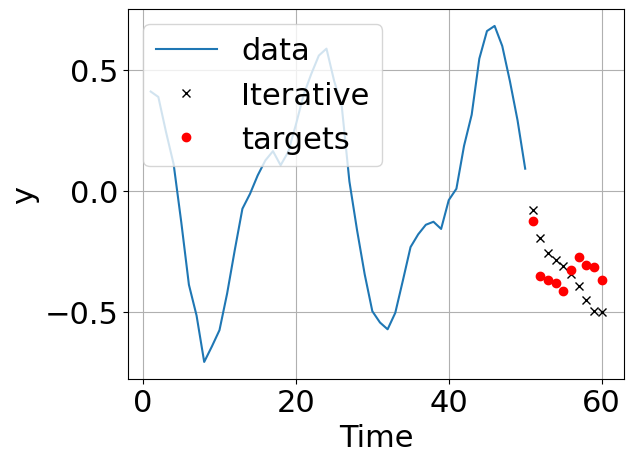

In [ ]:
# Create the plot
j=np.random.randint(X_test.shape[0])
plt.rcParams.update({'font.size': 22})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data')
plt.plot(list(range(n_steps + 1,n_steps + 11)),prediction,'x',color='black',label='Iterative')
plt.plot(list(range(n_steps + 1,n_steps + 11)),Y_test[j],'ro',label='targets')
plt.xlabel('Time')
plt.ylabel('y')

plt.grid(True)
plt.legend(loc='upper left')

plt.savefig('./Memoria/Toy model/Toyiterative{j}.png'.format(j=j))
# Show the plot
plt.show()


### Calculate metrics

In [ ]:
n_pred=10
y_pred=[]
for i in range(0,X_test.shape[0]):
  sequence=X_test[i].reshape(1,X_test.shape[1], 1)
  for j in range (0,n_pred):
    pred=model.predict(sequence[:,j:,:]) #predict next timestep with previous 1000 steps
    sequence=np.concatenate((sequence, pred.reshape(1, 1, 1)), axis=1) #add it to the sequence
  y_pred.append(sequence[0,50:,:])
  print(i)

Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 35ms/step
545
1/1 [==============================] - 0s 43ms/step
546
1/1 [==============================] - 0s 43ms/step
547
1/1 [==============================] - 0s 38ms/step
548
1/1 [==============================] - 0s 50ms/step
549
1/1 [==============================] - 0s 28ms/step
550
1/1 [==============================] - 0s 29ms/step
551
1/1 [==============================] - 0s 34ms/step
552
1/1 [==============================] - 0s 26ms/step
553
1/1 [==============================] - 0s 27ms/step
554
1/1 [==============================] - 0s 28ms/step
555
1/1 [==============================] - 0s 28ms/step
556
1/1 [==============================] - 0s 30ms/step
557
1/1 [==============================] - 0s 28ms/step
558
1/1 [==============================] - 0s 27ms/step
559
1/1 [==============================] - 0s 28ms/step
560
1/1 [==============================] - 0s 3

In [ ]:
predictions=np.array(y_pred)

In [ ]:
predictions.shape

(1000, 10, 1)

In [ ]:
print('last_mse: ', last_time_step_mse(Y_test,predictions.reshape((1000,10))))
print('mse: ', tf.reduce_mean(tf.keras.metrics.mean_squared_error(Y_test,predictions.reshape((1000,10)))))

last_mse:  tf.Tensor(0.040648215, shape=(), dtype=float32)
mse:  tf.Tensor(0.022077542, shape=(), dtype=float32)


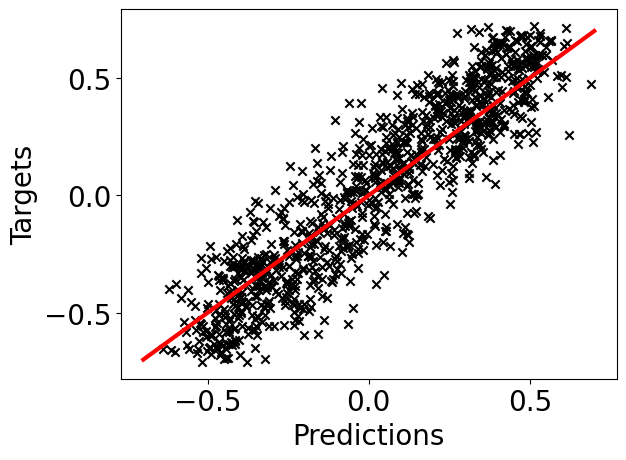

In [ ]:
  plt.scatter(predictions[:,-1,0], Y_test[:,-1], color='black',marker='x' ,label='Data points')
  x=[-0.7,0.7]
  y=[-0.7,0.7]
  plt.plot(x, y, color='red' ,label='x=y', linewidth=3.0)


  plt.xlabel('Predictions')
  plt.ylabel('Targets')

 # plt.title(title)
  #plt.legend(loc='upper right')
  plt.rcParams['font.size'] = 20
  plt.show()

## Targets of longer length

In [ ]:
print(X_train.shape,Y_train.shape)

(7000, 50, 1) (7000, 10)


In [ ]:
model10 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
tf.keras.layers.LSTM(20),
tf.keras.layers.Dense(10)
])
model10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 20)          1760      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model10.compile(loss='mse',
          optimizer='adam',
          metrics='mae')

history=model10.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

In [ ]:
model10.save('/content/drive/MyDrive/tfg_arturo_fredes/Toy_S-V_RNN.h5',save_format='h5')

In [ ]:
model10 = tf.keras.models.load_model('/content/drive/MyDrive/tfg_arturo_fredes/Toy_S-V_LSTM.h5')

In [ ]:
predictions=model10.predict(X_test)
predictions.shape

32/32 [==============================] - 0s 7ms/step


(1000, 10)

In [ ]:
#obtain metrics of the test dataset
print('last_mse: ', last_time_step_mse(Y_test,predictions.reshape((1000,10))))
print('mse: ', tf.reduce_mean(tf.keras.metrics.mean_squared_error(Y_test,predictions.reshape((1000,10)))))

last_mse:  tf.Tensor(0.015504029, shape=(), dtype=float32)
mse:  tf.Tensor(0.0074105295, shape=(), dtype=float32)


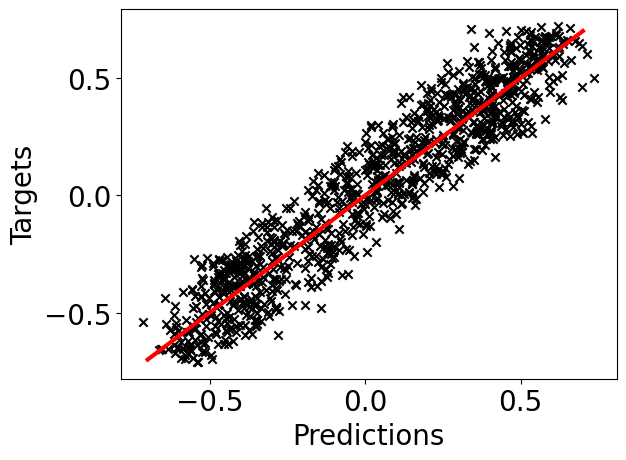

In [ ]:
  plt.scatter(predictions[:,-1], Y_test[:,-1], color='black',marker='x' ,label='Data points')
  x=[-0.7,0.7]
  y=[-0.7,0.7]
  plt.plot(x, y, color='red' ,label='x=y', linewidth=3.0)


  plt.xlabel('Predictions')
  plt.ylabel('Targets')

 # plt.title(title)
  #plt.legend(loc='upper right')
  plt.rcParams['font.size'] = 20
  plt.show()

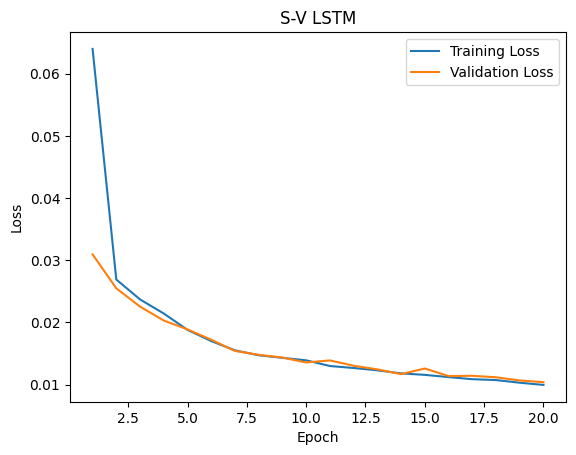

In [ ]:
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)

# Extract the validation loss values
val_loss = history.history['val_loss']

# Plot the training loss and validation loss vs. epoch
plt.rcParams.update({'font.size': 14})
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('S-V LSTM')
plt.legend()
plt.show()


In [ ]:
print(Y_test[0])

[0.3589286  0.43945253 0.43923825 0.3648016  0.33408096 0.2670196
 0.25016364 0.20452344 0.21485935 0.16678062]


1/1 [==============================] - 1s 1s/step
[[-0.09426461 -0.25004584 -0.34444955 -0.42060605 -0.46591312 -0.4877961
  -0.45882252 -0.46025398 -0.4179782  -0.33180583]]


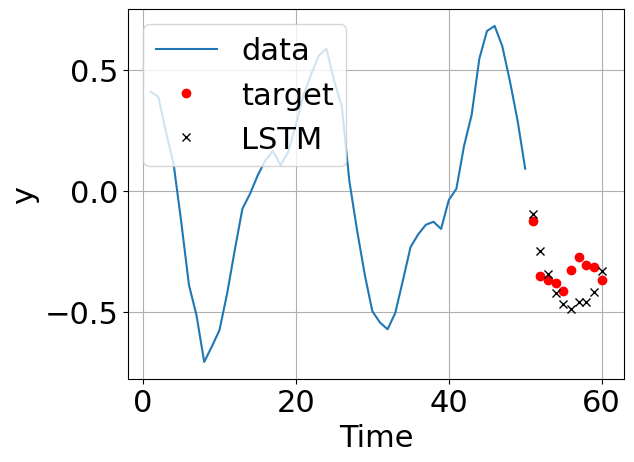

In [ ]:
# Create the plot
j=np.random.randint(X_test.shape[0])
pred=model10.predict(X_test[j].reshape(1, 50, 1))
print(pred)
plt.rcParams.update({'font.size': 22})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data')
plt.plot(list(range(n_steps + 1,n_steps + 11)),Y_test[j],'ro',label='target')
plt.plot(list(range(n_steps + 1,n_steps + 11)),pred[0],'x',color='black',label='LSTM')
plt.xlabel('Time')
plt.ylabel('y')

plt.grid(True)
plt.legend(loc='upper left')

plt.savefig('./Memoria/Toy model/ToySV{j}.png'.format(j=j))
# Show the plot
plt.show()


## Sequence-to-sequence

instead of training
the model to forecast the next 10 values only at the very last time step, we can
train it to forecast the next 10 values at each and every time step. In other words, we
can turn this sequence-to-vector RNN into a sequence-to-sequence RNN.



1.   loss will contain a term for the output of the RNN at
each and every time step
2.   more error gradients flowing through the model, and they won’t have to
flow only through time; they will also flow from the output of each time step. This
will both stabilize and speed up training.



In [ ]:
#now, every target will contain n_steps vectors of dimension 10, each one shifted by 10 steps.
n_steps = 50
target_len=10
Y = np.empty((10000, n_steps, target_len)) # each target is a sequence of 10D vectors
for step_ahead in range(1, target_len + 1):
  Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

It may be surprising that the targets will contain values that appear
in the inputs (there is a lot of overlap between X_train and
Y_train). Isn’t that cheating? Fortunately, not at all: at each time
step, the model only knows about past time steps, so it cannot look
ahead. It is said to be a causal model.

### The model

+ $W_x=n_{inputs} \times n_{neurons}$
+ $W_y=n_{neurons} \times n_{neurons}$
+ $b= n_{neurons}$

In [ ]:

model11 = tf.keras.models.Sequential([
tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
tf.keras.layers.SimpleRNN(20, return_sequences=True),
tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10))
])

model11.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 20)          440       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 10)         210       
 tributed)                                                       
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#To compute we use MSE in all sequences, but we just want the last one, so we define:
def last_time_step_mse(Y_true, Y_pred):
  return tf.keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model11.compile(loss="mse", optimizer=optimizer, metrics=['mae'])

In [ ]:
history=model11.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 33s 138ms/step - loss: 0.0528 - mae: 0.1715 - val_loss: 0.0414 - val_mae: 0.1533
Epoch 2/20
219/219 [==============================] - 25s 114ms/step - loss: 0.0365 - mae: 0.1419 - val_loss: 0.0314 - val_mae: 0.1305
Epoch 3/20
219/219 [==============================] - 25s 115ms/step - loss: 0.0312 - mae: 0.1300 - val_loss: 0.0302 - val_mae: 0.1271
Epoch 4/20
219/219 [==============================] - 23s 105ms/step - loss: 0.0288 - mae: 0.1243 - val_loss: 0.0268 - val_mae: 0.1200
Epoch 5/20
219/219 [==============================] - 26s 117ms/step - loss: 0.0267 - mae: 0.1191 - val_loss: 0.0283 - val_mae: 0.1230
Epoch 6/20
219/219 [==============================] - 25s 114ms/step - loss: 0.0254 - mae: 0.1156 - val_loss: 0.0238 - val_mae: 0.1117
Epoch 7/20
219/219 [==============================] - 25s 112ms/step - loss: 0.0227 - mae: 0.1068 - val_loss: 0.0222 - val_mae: 0.1054
Epoch 8/20
219/219 [==============================] - 2

In [ ]:
model11.save('/content/drive/MyDrive/tfg_arturo_fredes/Toy_S-S_RNN.h5',save_format='h5')

In [ ]:
model11 = tf.keras.models.load_model('/content/drive/MyDrive/tfg_arturo_fredes/Toy_S-S_LSTM.h5')

In [ ]:
predictions=model11.predict(X_test)

32/32 [==============================] - 1s 4ms/step


In [ ]:
#obtain metrics of the test dataset
print('last_timestep_mse: ', last_time_step_mse(Y_test[:,-1,:],predictions[:,-1,:]))
print('mse_last_series: ', tf.reduce_mean(tf.keras.metrics.mean_squared_error(Y_test[:,-1,:],predictions[:,-1,:])))
print('mse: ', tf.reduce_mean(tf.keras.metrics.mean_squared_error(Y_test,predictions)))

last_timestep_mse:  tf.Tensor(0.0052078986, shape=(), dtype=float32)
mse_last_series:  tf.Tensor(0.0032443197, shape=(), dtype=float32)
mse:  tf.Tensor(0.013907702, shape=(), dtype=float32)


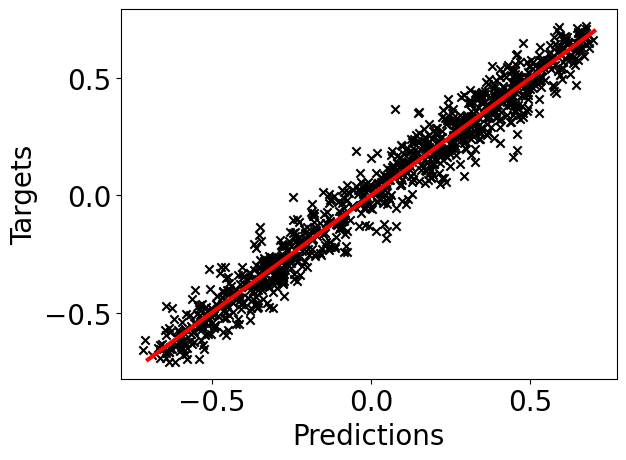

0.5195531237010964


In [ ]:


plt.scatter(predictions[:,-1,-1], Y_test[:,-1,-1], color='black',marker='x' ,label='Data points')
x=[-0.7,0.7]
y=[-0.7,0.7]
plt.plot(x, y, color='red' ,label='x=y', linewidth=3.0)


plt.xlabel('Predictions')
plt.ylabel('Targets')


#plt.legend(loc='upper right')
plt.rcParams['font.size'] = 20
plt.show()

rel_errors=1-predictions[:,-1,-1]/Y_test[:,-1,-1]
print(np.mean(abs(rel_errors)))

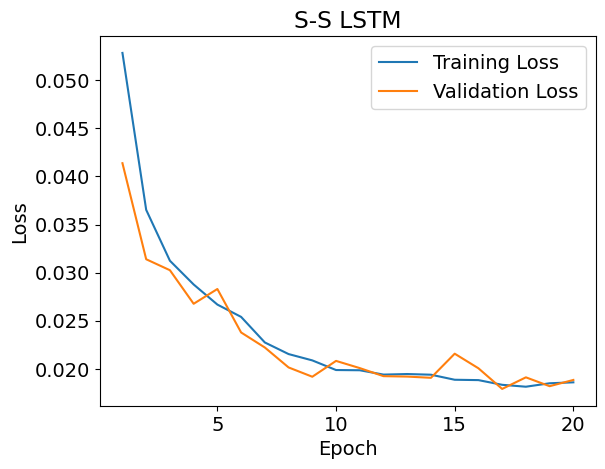

In [ ]:
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)

# Extract the validation loss values
val_loss = history.history['val_loss']

# Plot the training loss and validation loss vs. epoch
plt.rcParams.update({'font.size': 14})
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('S-S LSTM')
plt.legend()
plt.show()


In [ ]:
Y_test[0][-1]

array([ 0.48954555,  0.49957135,  0.39373642,  0.19652407, -0.00165057])

In [ ]:
j=666

1/1 [==============================] - 0s 32ms/step
(1000, 50, 1)
(1000, 50, 10)
(50, 10)
(1, 50, 10)
(50, 10)


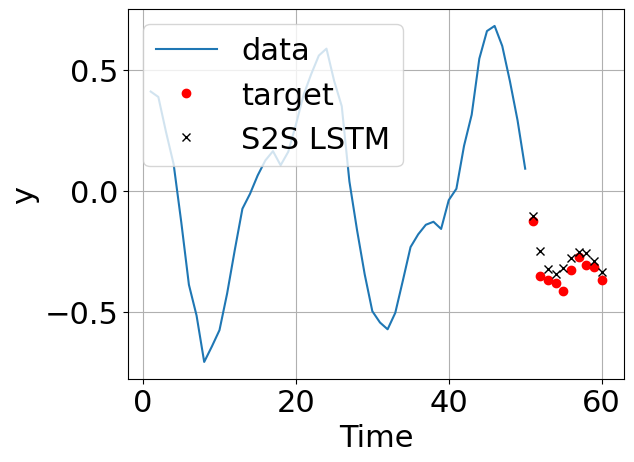

In [ ]:
# Create the plot
# Y_test = samples x time_steps x target_points
# Each Y_test[j] = time_steps x target_points
# Note that Y_test[j,:,i] is the function shifted i+1 steps ahead
# Y_test[j][-1] are the last target_points values of all the shifted functions
# By construction is the result of the problem
target_len=10
j=np.random.randint(X_test.shape[0])
pred=model11.predict(X_test[j].reshape(1, 50, 1))
print(X_test.shape)
print(Y_test.shape)
print(Y_test[j].shape)
print(pred.shape)
print(pred[0].shape)
plt.rcParams.update({'font.size': 22})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data')
plt.plot(list(range(n_steps + 1,n_steps + target_len+1)),Y_test[j][-1],'ro',label='target')
plt.plot(list(range(n_steps + 1,n_steps + target_len+1)),pred[0][-1],'x',color='black',label='S2S LSTM')
plt.xlabel('Time')
plt.ylabel('y')
plt.grid(True)
plt.legend(loc='upper left')

plt.savefig('./Memoria/Toy model/ToySS{j}.png'.format(j=j))
# Show the plot
plt.show()


In [ ]:
print(pred[0][-1])

[-0.10381997 -0.24774317 -0.32396817 -0.34203848 -0.31695253 -0.2774816
 -0.25216576 -0.25685656 -0.2901657  -0.333934  ]


In [ ]:
print(Y_test[j,-1,:])

[-0.12469684 -0.35178009 -0.36711562 -0.38172913 -0.41323498 -0.3251574
 -0.27108884 -0.30388969 -0.31411961 -0.36918533]


## Comparison

In [ ]:
#369
targets=[-0.1100965,  -0.00074714,  0.20269461,  0.44574091,  0.59603691,  0.64792305,  0.6854679,   0.63425922,  0.39932248,  0.16114831]

predictioniter=[-0.16900793, -0.0515433, 0.09343095, 0.24161375, 0.36944732,     0.45997006, 0.50725365, 0.51503241, 0.49318868, 0.45269486]

predictionsv=[-0.13872562,  0.02253694,  0.24200736,  0.4298273,   0.59902865,  0.6945635,   0.688558,    0.6105772,   0.447075,    0.22687666]

predictionss=[-0.16796991,  0.01526445,  0.24512602,  0.46920928,  0.6393409,   0.7183887,  0.6942009,   0.5741387,   0.40124986,  0.224827  ]
print('mse iter', tf.keras.metrics.mean_squared_error(targets, predictioniter))
print('mse sv', tf.keras.metrics.mean_squared_error(targets, predictionsv))
print('mse ss', tf.keras.metrics.mean_squared_error(targets, predictionss))

mse iter tf.Tensor(0.028611202, shape=(), dtype=float32)
mse sv tf.Tensor(0.00125157, shape=(), dtype=float32)
mse ss tf.Tensor(0.0020546964, shape=(), dtype=float32)


In [ ]:
#777
targets=[ 0.20246591,  0.15798452,  0.10150187, -0.06543814, -0.18160756, -0.42905688, -0.57140893, -0.6152429,  -0.66684449, -0.52638495]

predictioniter=[0.16021813, 0.11422468, 0.05270679, -0.02898178, -0.1253153,  -0.22152585, -0.29829827, -0.34025943, -0.34200042, -0.30909401]
predictionsv=[ 0.19925849,  0.15132374,  0.09325501, -0.0261448,  -0.18217686, -0.3275662,  -0.47679037, -0.561764,   -0.57857054, -0.5109884 ]
predictionss=[ 0.22946748,  0.21887366,  0.17028882,  0.0666975,  -0.08910027, -0.27799195, -0.46086815, -0.59681267, -0.6534969,  -0.61971116]
print('mse iter', tf.keras.metrics.mean_squared_error(targets, predictioniter))
print('mse sv', tf.keras.metrics.mean_squared_error(targets, predictionsv))
print('mse ss', tf.keras.metrics.mean_squared_error(targets, predictionss))

mse iter tf.Tensor(0.035659213, shape=(), dtype=float32)
mse sv tf.Tensor(0.0031809318, shape=(), dtype=float32)
mse ss tf.Tensor(0.007945313, shape=(), dtype=float32)


In [ ]:
#666
targets=[-0.12469684, -0.35178009, -0.36711562, -0.38172913, -0.41323498, -0.3251574, -0.27108884, -0.30388969, -0.31411961, -0.36918533]

predictioniter=[-0.07993993, -0.19285028, -0.25683239, -0.28700623, -0.30813506, -0.34105411, -0.39239162, -0.45157167, -0.49534014, -0.49915788]
predictionsv=[-0.09426461, -0.25004584, -0.34444955, -0.42060605, -0.46591312, -0.4877961, -0.45882252, -0.46025398, -0.4179782, -0.33180583]

predictionss=[-0.10381997, -0.24774317, -0.32396817, -0.34203848, -0.31695253, -0.2774816, -0.25216576, -0.25685656, -0.2901657, -0.333934]

print('mse iter', tf.keras.metrics.mean_squared_error(targets, predictioniter))
print('mse sv', tf.keras.metrics.mean_squared_error(targets, predictionsv))
print('mse ss', tf.keras.metrics.mean_squared_error(targets, predictionss))

mse iter tf.Tensor(0.0145953465, shape=(), dtype=float32)
mse sv tf.Tensor(0.011440503, shape=(), dtype=float32)
mse ss tf.Tensor(0.003062651, shape=(), dtype=float32)


In [ ]:
#167
targets=[0.28656942, 0.30506587, 0.29102856, 0.393228, 0.42841473, 0.55482924, 0.58361673, 0.5641903, 0.49873707, 0.2911389]

predictioniter=[0.41356322, 0.52044696, 0.6550682, 0.72954345, 0.6991624, 0.5694614, 0.38054353, 0.180585, 0.00828031, -0.11401201]
predictionsv=[0.28511092, 0.30845776, 0.37892592, 0.4666513, 0.5492427, 0.60207266, 0.58700025, 0.5144756, 0.35993567, 0.17989507]
predictionss=[0.27968687, 0.26198477, 0.30036953, 0.38884604, 0.50600815, 0.6132035, 0.66496503, 0.63139087, 0.5068392, 0.3132683]

print('mse iter', tf.keras.metrics.mean_squared_error(targets, predictioniter))
print('mse sv', tf.keras.metrics.mean_squared_error(targets, predictionsv))
print('mse ss', tf.keras.metrics.mean_squared_error(targets, predictionss))

mse iter tf.Tensor(0.09747546, shape=(), dtype=float32)
mse sv tf.Tensor(0.006408591, shape=(), dtype=float32)
mse ss tf.Tensor(0.0023126914, shape=(), dtype=float32)


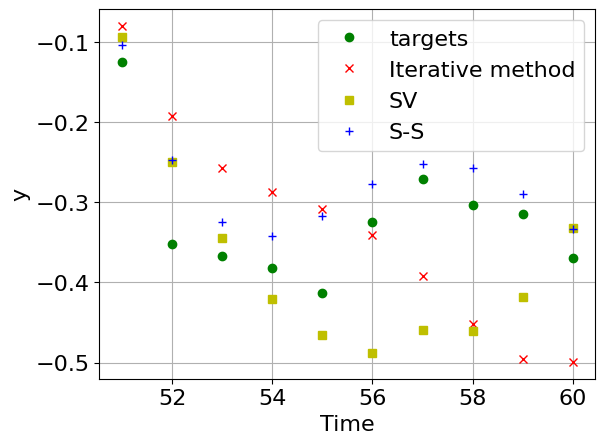

In [ ]:
# Create the plot
n_steps=50
plt.rcParams.update({'font.size': 16})
plt.plot(list(range(n_steps + 1,n_steps + 11)),targets,'go',label='targets')
plt.plot(list(range(n_steps + 1,n_steps + 11)),predictioniter,'rx',label='Iterative method')
plt.plot(list(range(n_steps + 1,n_steps + 11)),predictionsv,'ys',label='SV')
plt.plot(list(range(n_steps + 1,n_steps + 11)),predictionss,'b+',label='S-S')
plt.xlabel('Time')
plt.ylabel('y')

plt.grid(True)
plt.legend()

# Show the plot
plt.show()
